# Pandas Grouping Lanjutan

Pada notebook ini, kita akan mempelajari teknik-teknik grouping lanjutan menggunakan pandas. Grouping adalah operasi penting dalam analisis data untuk mengaggregasi dan menganalisis data berdasarkan kategori tertentu.

## Tujuan Pembelajaran

Setelah mempelajari notebook ini, Anda akan dapat:
1. Memahami konsep grouping kompleks di pandas
2. Menggunakan berbagai fungsi aggregasi
3. Melakukan multiple grouping
4. Menggunakan window functions
5. Menerapkan custom aggregation
6. Memahami hierarchical indexing

## Persiapan Dataset

Mari kita buat dataset yang lebih kompleks untuk pembelajaran grouping lanjutan:

In [71]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed untuk reprodusibilitas
np.random.seed(42)

# Buat dataset penjualan yang lebih kompleks
n_records = 1000

# Data kategorikal
products = ['Laptop', 'Smartphone', 'Tablet', 'Smartwatch']
categories = ['Premium', 'Standard', 'Budget']
regions = ['Barat', 'Timur', 'Utara', 'Selatan']
cities = {
    'Barat': ['Jakarta', 'Bandung', 'Serang'],
    'Timur': ['Surabaya', 'Malang', 'Denpasar'],
    'Utara': ['Medan', 'Palembang', 'Pekanbaru'],
    'Selatan': ['Makassar', 'Banjarmasin', 'Manado']
}

# Generate data
data = {
    'Tanggal': pd.date_range(start='2024-01-01', periods=n_records),
    'Produk': np.random.choice(products, n_records),
    'Kategori': np.random.choice(categories, n_records),
    'Region': np.random.choice(regions, n_records),
    'Harga': np.random.normal(8000000, 2000000, n_records),
    'Jumlah': np.random.randint(1, 10, n_records),
    'Biaya_Marketing': np.random.uniform(100000, 500000, n_records),
    'Rating': np.random.uniform(1, 5, n_records),
    'Customer_Age': np.random.normal(30, 8, n_records).astype(int)
}

# Tambahkan kota berdasarkan region
data['Kota'] = [np.random.choice(cities[region]) for region in data['Region']]

# Buat DataFrame
df = pd.DataFrame(data)

# Hitung beberapa kolom tambahan
df['Total_Penjualan'] = df['Harga'] * df['Jumlah']
df['Profit'] = df['Total_Penjualan'] * 0.3 - df['Biaya_Marketing']

# Tampilkan informasi dataset
print("Informasi Dataset:")
print(df.info())

# Tampilkan beberapa baris pertama
print("\nContoh Data:")
print(df.head())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Tanggal          1000 non-null   datetime64[ns]
 1   Produk           1000 non-null   object        
 2   Kategori         1000 non-null   object        
 3   Region           1000 non-null   object        
 4   Harga            1000 non-null   float64       
 5   Jumlah           1000 non-null   int64         
 6   Biaya_Marketing  1000 non-null   float64       
 7   Rating           1000 non-null   float64       
 8   Customer_Age     1000 non-null   int64         
 9   Kota             1000 non-null   object        
 10  Total_Penjualan  1000 non-null   float64       
 11  Profit           1000 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(4)
memory usage: 93.9+ KB
None

Contoh Data:
     Tanggal      Produk  Katego

## 1. Grouping dengan Multiple Aggregations

Pandas memungkinkan kita untuk melakukan beberapa operasi aggregasi sekaligus pada hasil grouping. Mari kita lihat beberapa contoh:

In [74]:
# 1. Multiple aggregations pada satu kolom
product_stats = df.groupby('Produk')['Total_Penjualan'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max'
]).round(2)

print("Statistik Penjualan per Produk:")
print(product_stats)

# 2. Different aggregations untuk kolom berbeda
region_analysis = df.groupby('Region').agg({
    'Total_Penjualan': ['sum', 'mean'],
    'Profit': ['sum', 'mean'],
    'Rating': ['mean', 'count'],
    'Customer_Age': ['mean', 'min', 'max']
}).round(2)

print("\nAnalisis per Region:")
print(region_analysis)

# 3. Custom aggregation dengan lambda function
category_analysis = df.groupby('Kategori').agg({
    'Total_Penjualan': ['sum', 'mean'],
    'Profit': ['sum', 'mean'],
    'Rating': ['mean', lambda x: (x >= 4).mean()],  # Proporsi rating >= 4
    'Customer_Age': lambda x: x.between(25, 35).mean()  # Proporsi customer berusia 25-35
}).round(2)

# Rename custom lambda functions
category_analysis.columns = category_analysis.columns.map(lambda x: 
    f"{x[0]}_{x[1]}" if isinstance(x[1], str) 
    else f"{x[0]}_custom"
)

print("\nAnalisis per Kategori:")
print(category_analysis)

Statistik Penjualan per Produk:
            count         mean          std         min           max
Produk                                                               
Laptop        258  39950275.30  25352652.99  5073188.08  1.205949e+08
Smartphone    230  39376092.38  21907386.55  2969923.09  9.070766e+07
Smartwatch    280  41523670.97  23852158.03  5008243.60  1.021309e+08
Tablet        232  40066362.89  24145860.69  3573545.30  1.065420e+08

Analisis per Region:
        Total_Penjualan                     Profit              Rating        \
                    sum         mean           sum         mean   mean count   
Region                                                                         
Barat      1.055911e+10  41901239.28  3.091525e+09  12267956.95   3.01   252   
Selatan    9.646797e+09  37830576.25  2.820074e+09  11059114.55   2.94   255   
Timur      1.086591e+10  42115943.91  3.185573e+09  12347182.69   2.93   258   
Utara      9.213874e+09  39207972.61  2.696130

## 2. Hierarchical Grouping

Pandas memungkinkan kita untuk melakukan grouping berdasarkan multiple columns, yang menghasilkan hierarchical index. Mari kita eksplorasi beberapa teknik:

Analisis Penjualan per Region dan Kategori:
                  count           sum         mean
Region  Kategori                                  
Barat   Budget       88  3.615262e+09  41082519.52
        Premium      81  3.429978e+09  42345412.74
        Standard     83  3.513872e+09  42335809.01
Selatan Budget       78  3.187707e+09  40868035.77
        Premium      91  3.408669e+09  37457897.61
        Standard     86  3.050421e+09  35470017.11
Timur   Budget       89  3.386130e+09  38046406.71
        Premium      92  4.192723e+09  45573073.67
        Standard     77  3.287061e+09  42689098.11
Utara   Budget       73  2.860832e+09  39189482.23
        Premium      77  2.838716e+09  36866438.45
        Standard     85  3.514326e+09  41345007.05

Hasil Unstack:
Kategori        Budget       Premium      Standard
Region                                            
Barat     3.615262e+09  3.429978e+09  3.513872e+09
Selatan   3.187707e+09  3.408669e+09  3.050421e+09
Timur     3.386130e+09

<Figure size 1200x600 with 0 Axes>

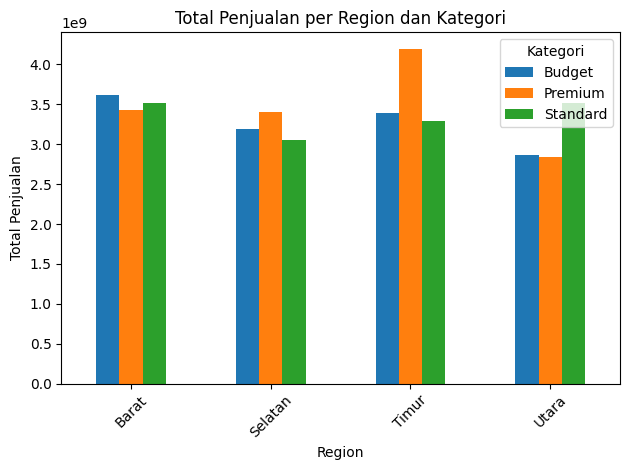

In [76]:
# 1. Basic hierarchical grouping
hierarchical_sales = df.groupby(['Region', 'Kategori'])['Total_Penjualan'].agg([
    'count',
    'sum',
    'mean'
]).round(2)

print("Analisis Penjualan per Region dan Kategori:")
print(hierarchical_sales)

# 2. Unstack hasil grouping
unstacked_sales = hierarchical_sales.unstack()
print("\nHasil Unstack:")
print(unstacked_sales['sum'])

# 3. Grouping dengan multiple levels dan multiple metrics
complex_analysis = df.groupby(['Region', 'Kategori', 'Produk']).agg({
    'Total_Penjualan': ['count', 'sum', 'mean'],
    'Profit': 'mean',
    'Rating': 'mean'
}).round(2)

print("\nAnalisis Kompleks Multi-level:")
print(complex_analysis.head(10))

# 4. Visualisasi hasil grouping
plt.figure(figsize=(12, 6))
unstacked_sales['sum'].plot(kind='bar')
plt.title('Total Penjualan per Region dan Kategori')
plt.xlabel('Region')
plt.ylabel('Total Penjualan')
plt.xticks(rotation=45)
plt.legend(title='Kategori')
plt.tight_layout()
plt.show()

## 3. Window Functions dan Rolling Calculations

Pandas menyediakan berbagai fungsi untuk melakukan perhitungan berbasis window, seperti rolling mean, cumulative sum, dan lainnya. Mari kita eksplorasi beberapa teknik:

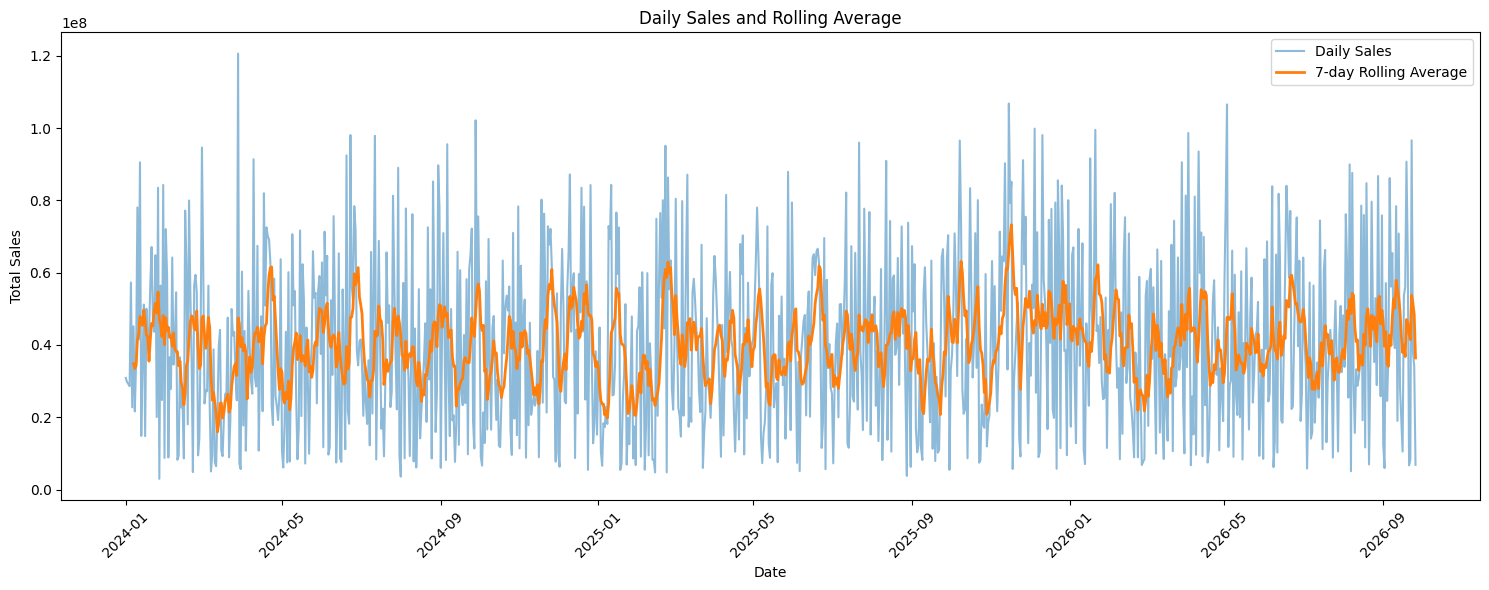


Product Rankings by Region (1 = highest sales):
Produk      Region 
Laptop      Barat      3.0
            Selatan    4.0
            Timur      1.0
            Utara      2.0
Smartphone  Barat      2.0
            Selatan    2.0
            Timur      4.0
            Utara      4.0
Smartwatch  Barat      1.0
            Selatan    1.0
            Timur      3.0
            Utara      1.0
Tablet      Barat      4.0
            Selatan    3.0
            Timur      2.0
            Utara      3.0
dtype: float64

Cumulative Percentage of Sales by Category:
Kategori    
Budget    1     0.227914
          10    0.546339
          14    0.938513
          16    1.321920
          22    1.656427
          25    2.296227
          30    2.363247
          32    2.818000
          35    3.031187
          38    3.344393
Name: Total_Penjualan, dtype: float64


/tmp/ipykernel_8756/684806340.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_ranks = df.groupby('Region').apply(


In [78]:
# 1. Time-based grouping dan rolling calculations
daily_sales = df.set_index('Tanggal').groupby(pd.Grouper(freq='D'))['Total_Penjualan'].sum()

# Calculate 7-day rolling average
rolling_7day = daily_sales.rolling(window=7).mean()

# Calculate cumulative sum
cumulative_sales = daily_sales.cumsum()

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(daily_sales.index, daily_sales.values, label='Daily Sales', alpha=0.5)
plt.plot(rolling_7day.index, rolling_7day.values, label='7-day Rolling Average', linewidth=2)
plt.title('Daily Sales and Rolling Average')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Rank dan Percentile calculations
# Rank products by total sales within each region
product_ranks = df.groupby('Region').apply(
    lambda x: x.groupby('Produk')['Total_Penjualan'].sum().rank(ascending=False)
).unstack()

print("\nProduct Rankings by Region (1 = highest sales):")
print(product_ranks)

# 3. Cumulative percentage within groups
def cum_percent(group):
    return group.cumsum() / group.sum() * 100

category_cum_sales = df.groupby('Kategori')['Total_Penjualan'].apply(cum_percent)
print("\nCumulative Percentage of Sales by Category:")
print(category_cum_sales.head(10))

## 4. Custom Aggregation Functions

Pandas memungkinkan kita untuk membuat fungsi aggregasi custom untuk kasus-kasus khusus. Mari kita lihat beberapa contoh:

In [81]:
# 1. Custom aggregation function untuk analisis penjualan
def sales_metrics(group):
    return pd.Series({
        'total_sales': group['Total_Penjualan'].sum(),
        'avg_sales': group['Total_Penjualan'].mean(),
        'sales_count': len(group),
        'high_value_sales': (group['Total_Penjualan'] > 50000000).sum(),
        'high_rating_ratio': (group['Rating'] >= 4).mean(),
        'profit_margin': (group['Profit'] / group['Total_Penjualan']).mean()
    })

# Apply custom aggregation
product_analysis = df.groupby('Produk').apply(sales_metrics)
print("Analisis Produk dengan Custom Metrics:")
print(product_analysis)

# 2. Custom function untuk analisis customer
def customer_segments(group):
    young = (group['Customer_Age'] < 25).sum()
    middle = ((group['Customer_Age'] >= 25) & (group['Customer_Age'] < 40)).sum()
    older = (group['Customer_Age'] >= 40).sum()
    
    return pd.Series({
        'young_customers': young,
        'middle_age_customers': middle,
        'older_customers': older,
        'avg_young_purchase': group[group['Customer_Age'] < 25]['Total_Penjualan'].mean(),
        'avg_middle_purchase': group[(group['Customer_Age'] >= 25) & (group['Customer_Age'] < 40)]['Total_Penjualan'].mean(),
        'avg_older_purchase': group[group['Customer_Age'] >= 40]['Total_Penjualan'].mean()
    })

# Apply customer segmentation analysis
region_segments = df.groupby('Region').apply(customer_segments)
print("\nAnalisis Segmentasi Customer per Region:")
print(region_segments)

# 3. Time-based custom analysis
def monthly_metrics(group):
    return pd.Series({
        'total_sales': group['Total_Penjualan'].sum(),
        'avg_daily_sales': group['Total_Penjualan'].mean(),
        'best_selling_product': group.groupby('Produk')['Total_Penjualan'].sum().idxmax(),
        'top_category': group.groupby('Kategori')['Total_Penjualan'].sum().idxmax(),
        'profit_ratio': (group['Profit'].sum() / group['Total_Penjualan'].sum())
    })

# Group by month and apply custom analysis
monthly_analysis = df.groupby(df['Tanggal'].dt.to_period('M')).apply(monthly_metrics)
print("\nAnalisis Bulanan:")
print(monthly_analysis)

Analisis Produk dengan Custom Metrics:
             total_sales     avg_sales  sales_count  high_value_sales  \
Produk                                                                  
Laptop      1.030717e+10  3.995028e+07        258.0              86.0   
Smartphone  9.056501e+09  3.937609e+07        230.0              72.0   
Smartwatch  1.162663e+10  4.152367e+07        280.0             106.0   
Tablet      9.295396e+09  4.006636e+07        232.0              80.0   

            high_rating_ratio  profit_margin  
Produk                                        
Laptop               0.224806       0.287726  
Smartphone           0.226087       0.286117  
Smartwatch           0.217857       0.288342  
Tablet               0.271552       0.286697  

Analisis Segmentasi Customer per Region:
         young_customers  middle_age_customers  older_customers  \
Region                                                            
Barat               71.0                 149.0             32.0 

/tmp/ipykernel_8756/3496366363.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_analysis = df.groupby('Produk').apply(sales_metrics)
/tmp/ipykernel_8756/3496366363.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  region_segments = df.groupby('Region').apply(customer_segments)


## Best Practices

1. **Pemilihan Metode Grouping**
   - Gunakan metode yang sesuai dengan tipe data
   - Pertimbangkan performa untuk dataset besar
   - Pilih level grouping yang tepat

2. **Optimasi Performa**
   - Hindari grouping yang terlalu kompleks
   - Gunakan method yang efisien
   - Perhatikan penggunaan memori

3. **Hasil yang Mudah Diinterpretasi**
   - Berikan nama yang jelas untuk hasil aggregasi
   - Gunakan format yang sesuai
   - Dokumentasikan custom functions

## Latihan

1. Buat dataset penjualan dengan minimal 1000 baris
2. Implementasikan berbagai teknik grouping yang telah dipelajari
3. Buat custom aggregation function
4. Visualisasikan hasil grouping

## Kesimpulan

Grouping lanjutan dalam pandas memungkinkan kita untuk:
1. Melakukan analisis data yang kompleks
2. Membuat custom metrics sesuai kebutuhan
3. Menghasilkan insight yang lebih mendalam
4. Mengoptimalkan performa analisis

## Referensi

1. Pandas Documentation
2. Python for Data Analysis
3. Effective Pandas
4. Data Analysis with Python Cookbook